In [15]:
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

export_dir = '/home/pgonzalez/Dropbox/quant_datasetshift/'
quantificators = ["CC", "ACC", "PCC", "PACC", "HDy", "DyS", "SMM", "EMQ","MLPE"]
error = "MAE"
dateexperiment = "2022_07_12_14_55"

results_dict={}
print("Loading results... ",sep="")
for quant_name in quantificators:
    results_dict[quant_name] = pd.read_csv("results/prior/results_%s_%s.csv" % (dateexperiment,quant_name),index_col=0)
    results_dict[quant_name]['p_train'] = results_dict[quant_name]['p_train'].round(2)
    results_dict[quant_name]['p_test'] = results_dict[quant_name]['p_test'].round(2)
    results_dict[quant_name]['prior_measure'] = results_dict[quant_name]['p_train']- results_dict[quant_name]['p_test']
    results_dict[quant_name]['prior_measure'] = results_dict[quant_name]['prior_measure'].round(1)
print("Done")

mean_error_methods = {}

writer = pd.ExcelWriter('results/prior/excel/errors_%s.xlsx' % dateexperiment, engine='xlsxwriter')
for quant_name in quantificators:
    results = results_dict[quant_name]
    results_mean = results.groupby(['p_train', 'p_test'])['error'].mean().reset_index()
    #convert to matrix form
    results_mean = results_mean.pivot(index='p_train', columns='p_test', values='error')
    mean_error_methods[quant_name]=results_mean.mean().mean()
    results_mean.columns = results_mean.columns.map(lambda x: "%.2f" % float(x))
    print("Results for method %s. Mean %s: %f" % (quant_name,error, mean_error_methods[quant_name]))
    cm = sns.light_palette('red', as_cmap=True)
    display(results_mean.style.format_index('{:.2f}').format('{:.3f}').background_gradient(cmap=cm,low=0,high=1))

    results_mean.to_excel(writer, sheet_name=quant_name)
    workbook = writer.book
    worksheet = writer.sheets[quant_name]
    # Apply a conditional format to the cell range.
    worksheet.conditional_format('B2:L12', {'type': '2_color_scale','min_type':'num','max_type':'num','min_value':'0','max_value':'1','min_color':'#f3f0f0','max_color':'#ff0000'})
writer.close()

Loading results... 
Done
Results for method CC. Mean MAE: 0.166632


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.01,0.001,0.094,0.190,0.286,0.384,0.480,0.577,0.673,0.769,0.865,0.960
0.10,0.113,0.076,0.034,0.015,0.051,0.086,0.131,0.167,0.207,0.252,0.288
0.20,0.123,0.090,0.054,0.026,0.024,0.050,0.089,0.118,0.153,0.193,0.224
0.30,0.112,0.083,0.056,0.026,0.013,0.032,0.065,0.089,0.120,0.152,0.180
0.40,0.123,0.096,0.068,0.039,0.014,0.020,0.047,0.072,0.102,0.132,0.161
0.50,0.142,0.114,0.087,0.057,0.029,0.013,0.029,0.054,0.083,0.113,0.141
0.60,0.161,0.132,0.105,0.075,0.046,0.020,0.017,0.039,0.069,0.098,0.127
0.70,0.179,0.150,0.122,0.089,0.060,0.033,0.013,0.026,0.058,0.088,0.117
0.80,0.224,0.191,0.158,0.123,0.087,0.056,0.023,0.022,0.049,0.085,0.118


Results for method ACC. Mean MAE: 0.081318


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.01,0.180,0.177,0.251,0.325,0.370,0.412,0.398,0.394,0.369,0.340,0.304
0.10,0.019,0.029,0.035,0.044,0.044,0.059,0.063,0.071,0.069,0.053,0.005
0.20,0.013,0.020,0.024,0.028,0.029,0.031,0.034,0.043,0.045,0.039,0.005
0.30,0.012,0.018,0.022,0.023,0.023,0.026,0.027,0.032,0.034,0.032,0.002
0.40,0.009,0.018,0.019,0.018,0.018,0.020,0.020,0.023,0.023,0.023,0.006
0.50,0.008,0.020,0.020,0.018,0.018,0.019,0.019,0.020,0.020,0.020,0.005
0.60,0.005,0.027,0.026,0.024,0.024,0.023,0.022,0.021,0.018,0.018,0.011
0.70,0.008,0.026,0.025,0.026,0.023,0.023,0.021,0.020,0.019,0.019,0.010
0.80,0.004,0.036,0.036,0.035,0.033,0.029,0.029,0.025,0.022,0.023,0.017


Results for method PCC. Mean MAE: 0.159310


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.01,0.466,0.369,0.271,0.172,0.073,0.027,0.125,0.224,0.322,0.421,0.520
0.10,0.248,0.183,0.116,0.049,0.020,0.085,0.154,0.219,0.286,0.355,0.420
0.20,0.130,0.085,0.040,0.018,0.055,0.100,0.148,0.191,0.237,0.287,0.331
0.30,0.107,0.072,0.036,0.011,0.038,0.074,0.111,0.145,0.181,0.221,0.255
0.40,0.137,0.104,0.070,0.035,0.010,0.034,0.068,0.100,0.136,0.173,0.206
0.50,0.173,0.139,0.106,0.071,0.037,0.011,0.032,0.064,0.098,0.133,0.167
0.60,0.213,0.179,0.144,0.108,0.072,0.039,0.012,0.030,0.066,0.102,0.137
0.70,0.264,0.228,0.193,0.153,0.117,0.081,0.043,0.012,0.030,0.069,0.105
0.80,0.335,0.289,0.240,0.191,0.143,0.097,0.046,0.009,0.049,0.099,0.146


Results for method PACC. Mean MAE: 0.035140


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.01,0.008,0.055,0.065,0.074,0.087,0.108,0.127,0.142,0.132,0.091,0.007
0.10,0.002,0.028,0.024,0.025,0.026,0.038,0.044,0.059,0.071,0.067,0.000
0.20,0.005,0.018,0.020,0.022,0.024,0.030,0.034,0.045,0.050,0.048,0.001
0.30,0.007,0.020,0.020,0.021,0.020,0.024,0.027,0.033,0.037,0.036,0.000
0.40,0.005,0.017,0.017,0.016,0.016,0.017,0.020,0.024,0.025,0.024,0.002
0.50,0.005,0.019,0.018,0.016,0.016,0.017,0.019,0.021,0.022,0.021,0.003
0.60,0.003,0.026,0.023,0.020,0.020,0.018,0.018,0.018,0.018,0.016,0.004
0.70,0.002,0.029,0.025,0.025,0.022,0.019,0.020,0.018,0.017,0.016,0.004
0.80,0.003,0.045,0.044,0.038,0.033,0.024,0.024,0.020,0.018,0.016,0.004


Results for method HDy. Mean MAE: 0.036983


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.01,0.011,0.040,0.069,0.094,0.121,0.140,0.163,0.180,0.197,0.217,0.219
0.10,0.005,0.020,0.025,0.026,0.028,0.028,0.033,0.033,0.033,0.035,0.024
0.20,0.003,0.021,0.026,0.025,0.029,0.028,0.031,0.032,0.030,0.031,0.017
0.30,0.003,0.016,0.018,0.018,0.019,0.018,0.020,0.020,0.018,0.016,0.010
0.40,0.004,0.017,0.019,0.017,0.018,0.017,0.019,0.018,0.017,0.014,0.007
0.50,0.007,0.016,0.017,0.018,0.017,0.018,0.018,0.019,0.016,0.015,0.008
0.60,0.007,0.018,0.021,0.021,0.020,0.019,0.020,0.021,0.017,0.015,0.006
0.70,0.007,0.017,0.020,0.021,0.019,0.022,0.022,0.023,0.021,0.018,0.005
0.80,0.009,0.023,0.027,0.027,0.026,0.025,0.025,0.026,0.022,0.022,0.009


Results for method DyS. Mean MAE: 0.030958


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.01,0.017,0.045,0.061,0.081,0.099,0.119,0.138,0.154,0.174,0.194,0.195
0.10,0.006,0.017,0.020,0.024,0.026,0.030,0.035,0.037,0.036,0.038,0.024
0.20,0.005,0.016,0.019,0.021,0.022,0.023,0.024,0.026,0.025,0.024,0.014
0.30,0.005,0.015,0.016,0.018,0.017,0.017,0.019,0.020,0.018,0.018,0.007
0.40,0.005,0.014,0.016,0.016,0.015,0.016,0.018,0.017,0.016,0.015,0.008
0.50,0.006,0.015,0.017,0.018,0.018,0.018,0.019,0.020,0.017,0.015,0.007
0.60,0.008,0.019,0.020,0.019,0.018,0.018,0.019,0.019,0.017,0.015,0.007
0.70,0.020,0.025,0.026,0.023,0.020,0.020,0.020,0.019,0.016,0.013,0.006
0.80,0.014,0.023,0.025,0.023,0.023,0.022,0.022,0.022,0.018,0.015,0.006


Results for method SMM. Mean MAE: 0.033705


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.01,0.020,0.047,0.075,0.099,0.118,0.132,0.136,0.128,0.117,0.096,0.050
0.10,0.008,0.018,0.019,0.023,0.025,0.030,0.033,0.037,0.042,0.041,0.014
0.20,0.009,0.018,0.021,0.023,0.023,0.024,0.028,0.031,0.032,0.033,0.013
0.30,0.009,0.018,0.020,0.020,0.019,0.020,0.024,0.024,0.026,0.024,0.009
0.40,0.010,0.017,0.018,0.018,0.018,0.019,0.020,0.022,0.023,0.021,0.010
0.50,0.011,0.019,0.020,0.020,0.020,0.020,0.022,0.023,0.023,0.022,0.009
0.60,0.010,0.021,0.021,0.020,0.018,0.017,0.019,0.018,0.017,0.015,0.006
0.70,0.008,0.025,0.025,0.022,0.021,0.020,0.019,0.019,0.017,0.015,0.005
0.80,0.024,0.032,0.030,0.027,0.022,0.023,0.022,0.022,0.020,0.019,0.009


Results for method EMQ. Mean MAE: 0.032465


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.01,0.028,0.064,0.089,0.111,0.122,0.142,0.144,0.148,0.127,0.079,0.001
0.10,0.004,0.017,0.020,0.024,0.022,0.028,0.027,0.030,0.027,0.023,0.012
0.20,0.003,0.014,0.017,0.019,0.018,0.022,0.022,0.025,0.021,0.019,0.009
0.30,0.003,0.014,0.017,0.018,0.015,0.019,0.020,0.021,0.018,0.014,0.007
0.40,0.002,0.014,0.016,0.015,0.015,0.016,0.017,0.019,0.017,0.014,0.006
0.50,0.002,0.014,0.016,0.015,0.015,0.017,0.018,0.020,0.017,0.015,0.006
0.60,0.002,0.016,0.018,0.017,0.017,0.015,0.017,0.017,0.014,0.011,0.006
0.70,0.002,0.016,0.018,0.017,0.018,0.017,0.018,0.017,0.014,0.012,0.006
0.80,0.001,0.020,0.022,0.021,0.022,0.018,0.019,0.018,0.015,0.013,0.006


Results for method MLPE. Mean MAE: 0.362476


p_test,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00
p_train,,,,,,,,,,,
0.01,0.010,0.088,0.188,0.288,0.389,0.490,0.590,0.690,0.790,0.890,0.990
0.10,0.100,0.001,0.099,0.199,0.299,0.400,0.500,0.600,0.700,0.800,0.900
0.20,0.200,0.101,0.002,0.099,0.199,0.300,0.400,0.500,0.600,0.700,0.800
0.30,0.300,0.201,0.102,0.002,0.099,0.200,0.300,0.400,0.500,0.600,0.700
0.40,0.400,0.301,0.202,0.102,0.001,0.100,0.200,0.300,0.400,0.500,0.600
0.50,0.500,0.402,0.302,0.202,0.101,0.000,0.100,0.200,0.300,0.400,0.500
0.60,0.600,0.502,0.402,0.302,0.201,0.100,0.000,0.100,0.200,0.300,0.400
0.70,0.700,0.602,0.502,0.402,0.301,0.200,0.100,0.000,0.100,0.200,0.300
0.80,0.800,0.702,0.602,0.502,0.401,0.300,0.200,0.100,0.000,0.100,0.200


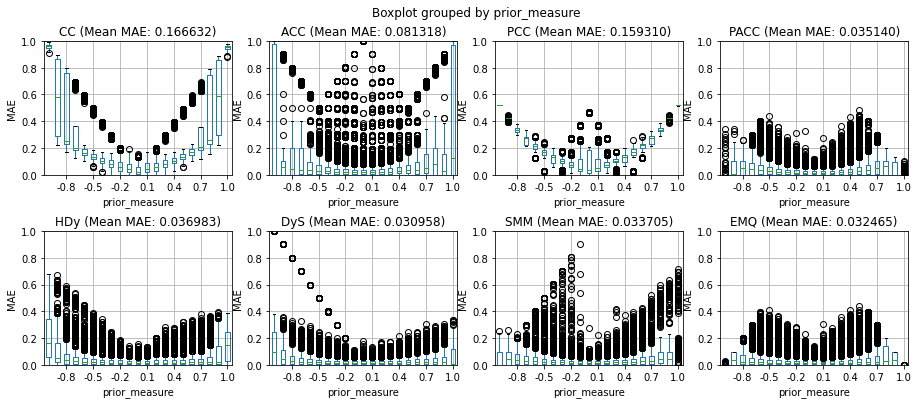

In [16]:
import matplotlib.ticker as ticker

quantificators = ["CC", "ACC", "PCC", "PACC", "HDy","DyS","SMM", "EMQ"]
n_cols=4
fig, ax = plt.subplots(2,n_cols,figsize=(15,6))
pd.set_option('display.max_rows', 500)

for k,quant_name in enumerate(quantificators):
    results = results_dict[quant_name]
    ax[k//n_cols][k%n_cols].set_ylim(0, 1)
    ax[k//n_cols][k%n_cols].set_ylabel(error)
    ax[k//n_cols][k%n_cols].tick_params(axis='x', rotation=90)
    fig.tight_layout()
    results.boxplot(ax=ax[k//n_cols][k%n_cols],column='error',by='prior_measure')
    ax[k//n_cols][k%n_cols].xaxis.set_major_locator(ticker.MultipleLocator(3))
    ax[k//n_cols][k%n_cols].set_title("%s (Mean %s: %f)"  % (quant_name,error,mean_error_methods[quant_name]))

### Tables and charts to be included in a paper

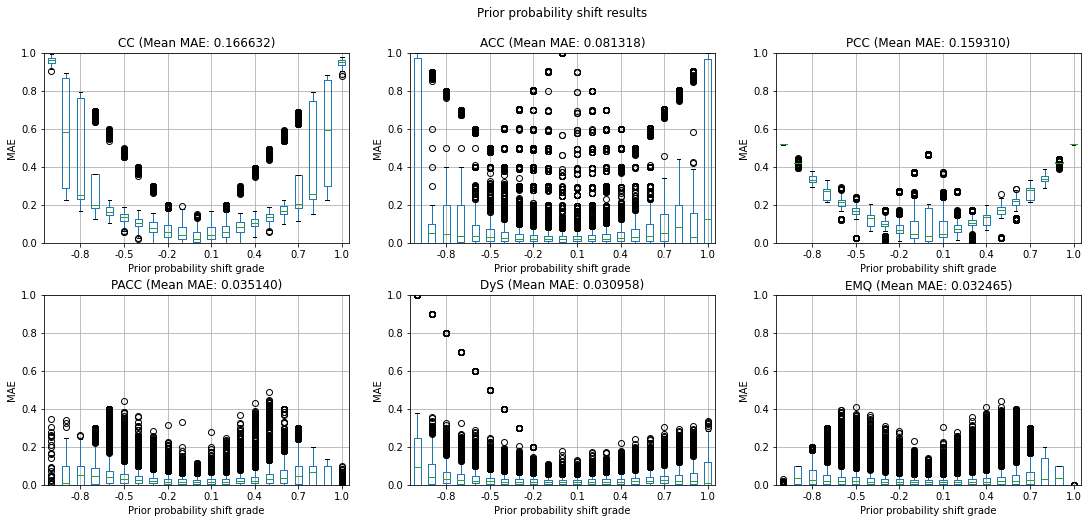

In [17]:
quantificators = ["CC", "ACC", "PCC", "PACC","DyS", "EMQ"]
n_cols = 3
fig, ax = plt.subplots(2,n_cols,figsize=(18,8))
for k,quant_name in enumerate(quantificators):
    results = results_dict[quant_name]
    ax[k//n_cols][k%n_cols].set_ylim(0, 1)
    ax[k//n_cols][k%n_cols].set_ylabel(error)
    ax[k//n_cols][k%n_cols].tick_params(axis='x', rotation=90)
    fig.tight_layout()
    results.boxplot(ax=ax[k//n_cols][k%n_cols],column='error',by='prior_measure')
    plt.suptitle('Prior probability shift results')
    ax[k//n_cols][k%n_cols].set_xlabel("Prior probability shift grade")
    ax[k//n_cols][k%n_cols].xaxis.set_major_locator(ticker.MultipleLocator(3))
    ax[k//n_cols][k%n_cols].set_title("%s (Mean %s: %f)"  % (quant_name,error,mean_error_methods[quant_name]))
plt.savefig(os.path.join(export_dir,"images/priorresults.pdf"),format='pdf',bbox_inches='tight')
plt.savefig(os.path.join(export_dir,"images/priorresults.png"),format='png',bbox_inches='tight')

## Main table to put in the paper with results for prior probability shift

In [21]:
from utils.wilcoxon import wilcoxon_test
quantificators = ["CC", "ACC", "PCC", "PACC", "DyS", "EMQ"]
global_results = pd.DataFrame(columns = quantificators,index=np.linspace(-1,1,21).round(1),dtype=float)
for k,quant_name in enumerate(quantificators):
    results = results_dict[quant_name]
    results = results.groupby(by='prior_measure')['error'].mean()
    global_results.loc[:, quant_name] = results

global_results_style = global_results.style.format('{:.3f}').format_index('{:.1f}')

#We want to make a statistical test for each row, to compare methods for the same degree of covariate shift
for i,r in global_results.iterrows():
        #compute the best method for this experiment
        prior_measure = r.name
        best_method = r.index[r.argmin()]
        
        #print("Computing statistical test for experiment covariate degree=%f, p_test=%s. Winner method %s" % (covariate_measure,p_test,best_method))
        #Get data for the winner method
        results_best = results_dict[best_method].loc[(results_dict[best_method]['prior_measure']==prior_measure),'error'].to_numpy()
        #We need to get all the rows in results that matches this experiment for each method
        for quant_name in quantificators:
            if quant_name!=best_method:
                #print("Comparing %s with %s" % (best_method,quant_name))
                results_method = results_dict[quant_name].loc[results_dict[quant_name]['prior_measure']==prior_measure,'error'].to_numpy()
                global_results_style.set_properties(subset=(prior_measure, quant_name),**wilcoxon_test(results_best,results_method))


result = global_results_style.highlight_min(axis=1,props='textbf:--rwrap;')
display(result)
columns = 'r'*len(quantificators)
with open(os.path.join(export_dir,'tables/prior_table.tex'), 'w') as f:
    f.write(result.to_latex(hrules=True,column_format="l|"+columns).replace(' 0.',' .').replace('{0.','{.'))

,CC,ACC,PCC,PACC,DyS,EMQ
-1.0,0.960,0.304,0.520,0.007,0.195,0.001
-0.9,0.577,0.173,0.421,0.046,0.109,0.045
-0.8,0.415,0.143,0.336,0.067,0.076,0.053
-0.7,0.313,0.126,0.263,0.065,0.055,0.050
-0.6,0.242,0.110,0.202,0.055,0.045,0.043
-0.5,0.187,0.097,0.149,0.043,0.037,0.039
-0.4,0.141,0.078,0.122,0.034,0.030,0.033
-0.3,0.103,0.062,0.101,0.028,0.025,0.028
-0.2,0.071,0.049,0.096,0.024,0.022,0.024
-0.1,0.053,0.038,0.102,0.021,0.019,0.021


In [19]:
for quant_name in quantificators:
    results = results_dict[quant_name]
    results_mean = results.groupby(['p_train', 'p_test'])['error'].mean().reset_index()
    #convert to matrix form
    results_mean = results_mean.pivot(index='p_train', columns='p_test', values='error')
    mean_error_methods[quant_name]=results_mean.mean().mean()
    results_mean.columns = results_mean.columns.map(lambda x: "%.2f" % float(x))
    results_mean.columns.name=None
    results_mean.index.name=None
    cm = sns.light_palette('red', as_cmap=True)
    f = open(os.path.join(export_dir,"tables/prior_results_%s.tex" % (quant_name)), "w")
    f.write(results_mean.style.format_index('{:.2f}').format('{:.3f}').background_gradient(cmap=cm,low=0,high=1).to_latex(convert_css=True,
                                caption="Results for \emph{prior probability shift} for method %s. In rows, prevalence for the train set; in columns, prevalence for test sample. Mean %s: %f." % (quant_name,error,mean_error_methods[quant_name]),
                                column_format='lccccccccccc', position='H',label="tab:prior%s"%quant_name))
    f.close()